# Clustering word arcs across narrative time

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
mpl.style.use('bmh')

In [3]:
import numpy as np

In [4]:
from lint_analysis.bin_counts import cache

In [5]:
tokens = cache.token_counts(10000)

In [6]:
import re

from collections import OrderedDict

tokens = OrderedDict([
    (t, c) for t, c in tokens.items()
    if not re.match('^[0-9ivx.]+$', t)
])

In [7]:
data = []

for i, (token, count) in enumerate(tokens.items()):
    
    series = cache.token_series(token)
    exp_var = series.sum() * (1/100) * (1 - 1/100)
    
    data.append((count, series.var(), exp_var))
    
    if i % 1000 == 0: print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [8]:
import pandas as pd

df = pd.DataFrame(
    data,
    columns=('count', 'var', 'exp'),
    index=tokens.keys(),
)

In [9]:
import math

df['score'] = df.index.map(
    lambda t: df.loc[t]['var'] / df.loc[t]['exp']
)

In [10]:
top = df.sort_values('score', ascending=False).head(1000)

In [11]:
import random

shuffled = list(top.index)
random.shuffle(shuffled)

In [12]:
series = {
    token: cache.token_series(token)
    for token in top.index
}

In [13]:
from itertools import combinations
from scipy.spatial import distance

In [14]:
d = []
for i, (t1, t2) in enumerate(combinations(shuffled, 2)):
    
    s1 = series[t1]
    s2 = series[t2]
    
    d.append(distance.euclidean(s1/s1.sum(), s2/s2.sum()))

In [15]:
from scipy.cluster.hierarchy import linkage, dendrogram

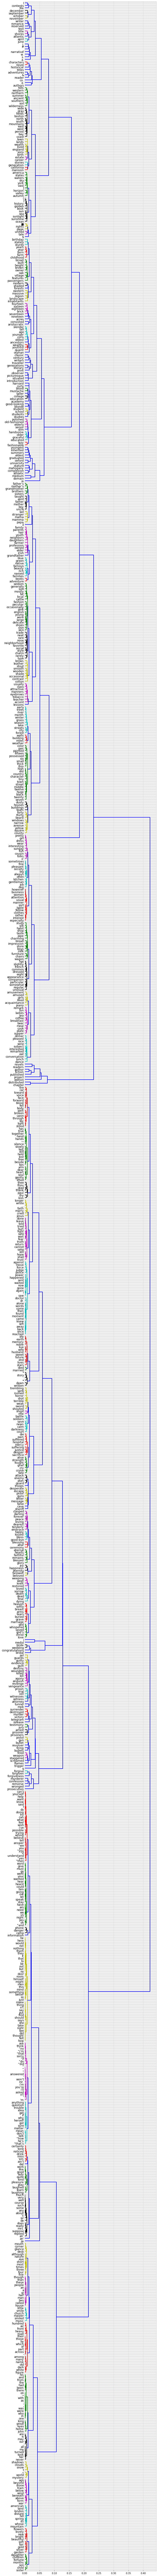

In [16]:
link = linkage(d, method='ward')

plt.figure(figsize=(10, 200))

dendrogram(
    link,
    labels=shuffled,
    orientation='right',
    distance_sort='ascending',
    leaf_font_size=12,
    color_threshold=0.01,
)

plt.show()

In [17]:
from scipy.cluster.hierarchy import fcluster

In [18]:
import math

from scipy.ndimage.measurements import center_of_mass
from itertools import cycle
    
class Cohorts(dict):
        
    def add(self, key, label, tokens):
        
        if type(tokens) is str:
            tokens = list(map(str.strip, token_str.strip().splitlines()))

        self[key] = (label, tokens)
        
    def density(self, key):
        _, tokens = self[key]
        counts = np.array([cache.token_series(token) for token in tokens]).sum(0)
        return counts / counts.sum()
        
    def center_of_mass(self, key):
        density = self.density(key)
        return center_of_mass(np.array(density))[0]
    
    def order_center_of_mass(self):
        return sorted(self.keys(), key=lambda k: self.center_of_mass(k))
    
    def order_max_density(self):
        return sorted(self.keys(), key=lambda k: np.argmax(self.density(k)))
    
    def plot_multiples(self, cols=4, min_tokens=3):
        
        keys = [k for k in self.keys() if len(self[k][1]) >= min_tokens]

        # Get row count and figure size.
        rows = math.ceil(len(keys) / cols)
        
        plt.figure(figsize=(cols*2.5, rows*2.5))
        
        keys = reversed(keys)
        
        for i, key in enumerate(keys):
            
            label, tokens = self[key]
            
            if len(tokens) < min_tokens:
                continue
            
            ax = plt.subplot2grid((rows, cols), (math.floor(i/cols), i%cols))
            
            for token in tokens:

                # Configure axes.
                ax.set_title(label, fontsize=8)
                ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
                ax.tick_params(labelsize=8)

                # Plot the series.
                series = cache.token_series(token.strip())
                ax.plot(series/series.sum(), c='#1d6ae5', lw=0.5)
                
        plt.tight_layout(h_pad=1)
        plt.show()
        
    def plot_cohorts(self, cohorts, title=None, w=5, h=5):
            
        plt.figure(figsize=(w, h))
        
        lines = []
        for key in cohorts:
            
            _, tokens = self[key]
            
            for token in tokens:
                series = cache.token_series(token)
                line, = plt.plot(series/series.sum(), label=token, lw=1)
                lines.append(line)

        plt.legend(
            handles=lines,
            bbox_to_anchor=(1.03, 1),
            loc=2,
            borderaxespad=0,
        )
        
        if title:
            plt.title(title)
            
        plt.axhline(1/100, c='black', lw=0.5, alpha=0.75)

        plt.xlabel('Narrative time')
        plt.ylabel('Relative frequency')

In [19]:
from textwrap import wrap
from boltons.iterutils import chunked

groups = fcluster(link, 0.01, 'distance')

cohorts = Cohorts()

for gid in range(min(groups), max(groups)+1):
    
    tokens = []
    for i, j in enumerate(groups):
        if j == gid:
            tokens.append(shuffled[i])

    dtokens = tokens[:10]

    dtokens[0] = '%d: %s' % (gid, dtokens[0])

    if len(tokens) > 10:
        dtokens.append('(%d more)' % (len(tokens) - 10))

    lines = wrap(', '.join(dtokens), 30)
    title = '\n'.join(lines)
    cohorts.add(gid, title, tokens)

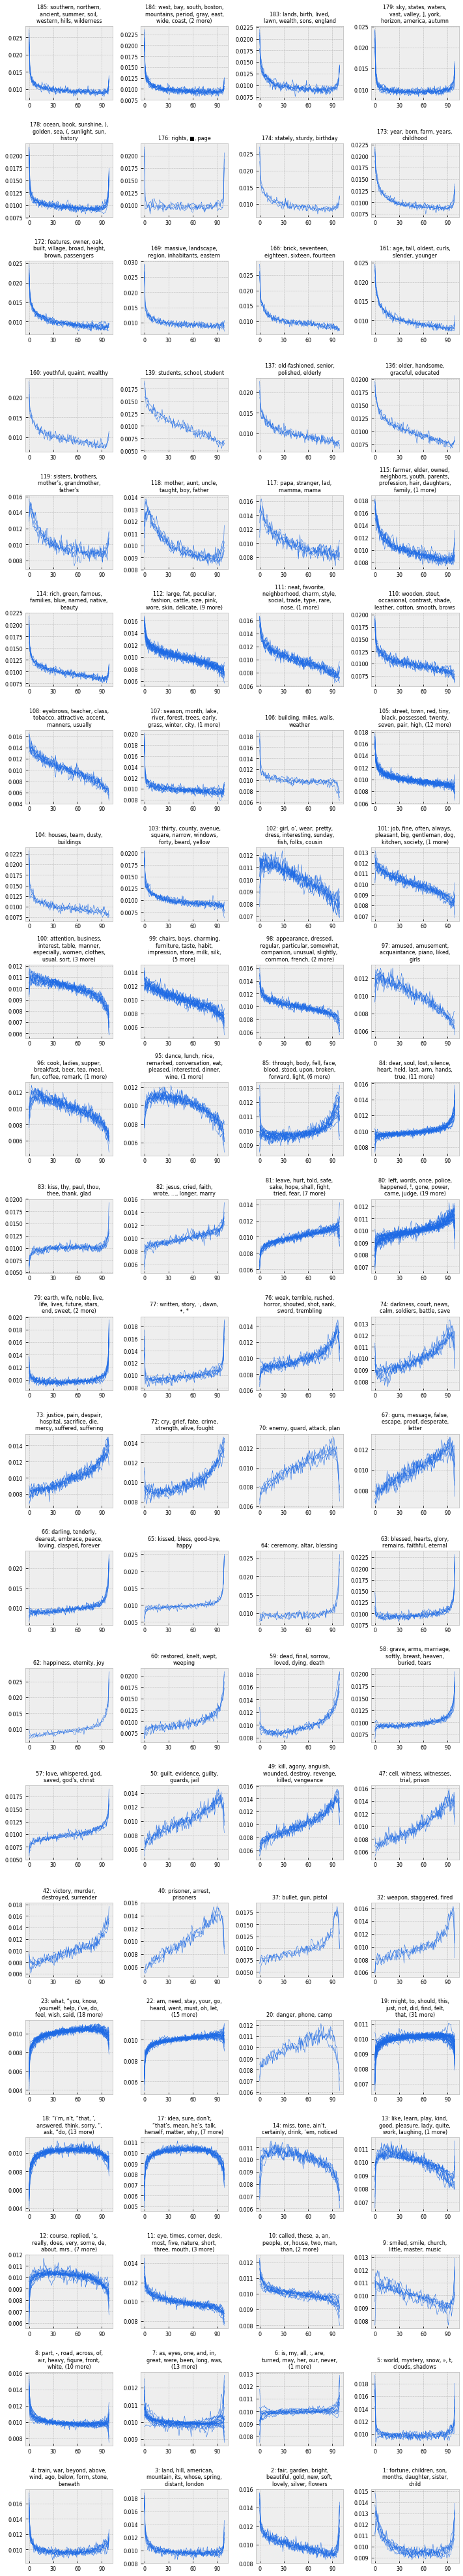

In [20]:
cohorts.plot_multiples()

# Descriptions of people and things

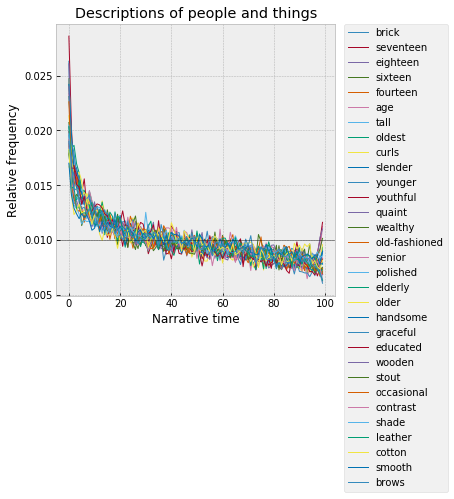

In [21]:
cohorts.plot_cohorts([166, 161, 160, 137, 136, 110], 'Descriptions of people and things')

# Education

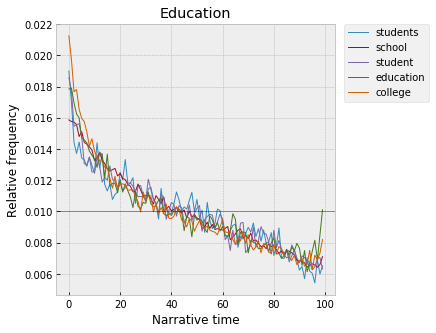

In [22]:
cohorts.plot_cohorts([139, 143], 'Education')

# Geography, location, environment

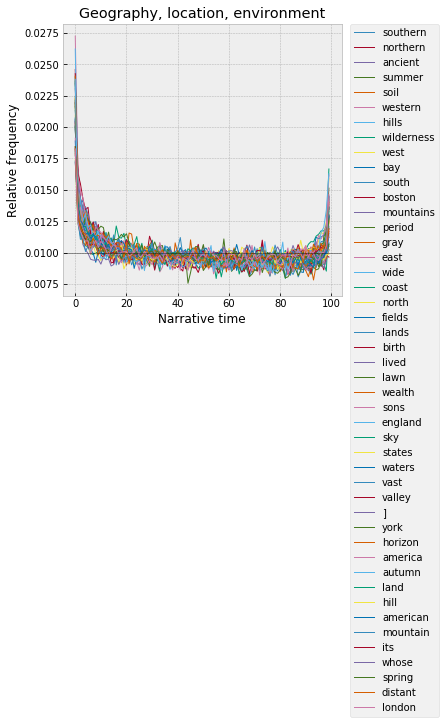

In [23]:
cohorts.plot_cohorts([185, 184, 183, 179, 3], 'Geography, location, environment')

# Sunny, cloudy

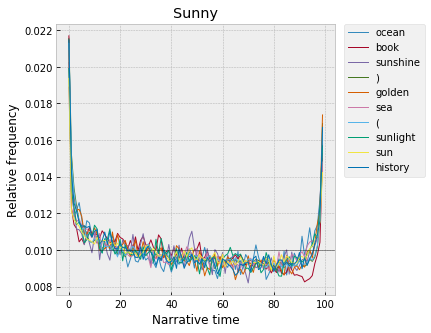

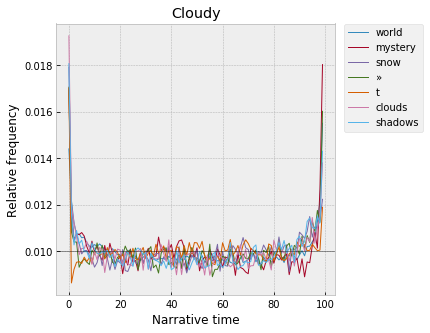

In [24]:
cohorts.plot_cohorts([178], 'Sunny')
cohorts.plot_cohorts([5], 'Cloudy')

# Family, youth

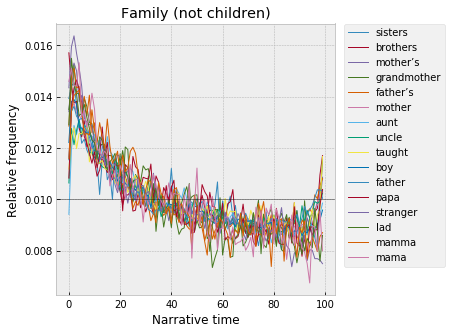

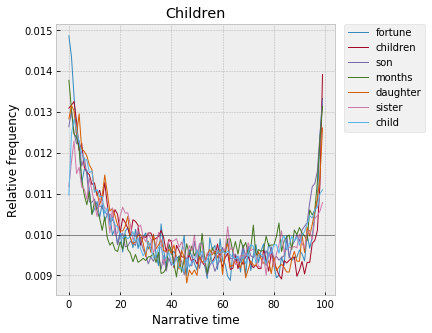

In [25]:
cohorts.plot_cohorts([119, 118, 117], 'Family (not children)')
cohorts.plot_cohorts([1], 'Children')

# Women, clothes, amusement

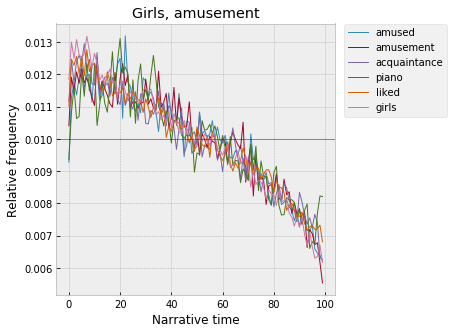

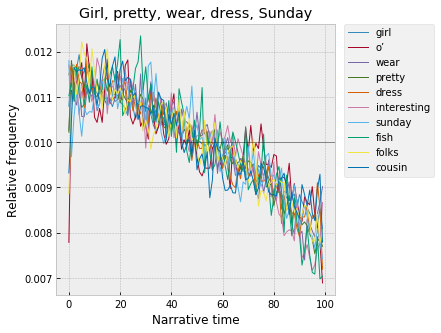

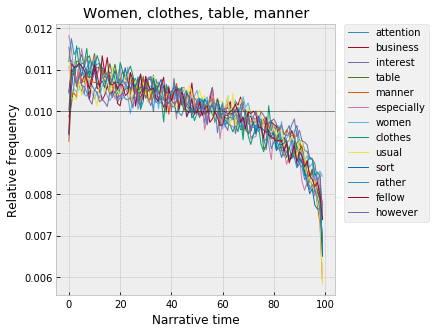

In [26]:
cohorts.plot_cohorts([97], 'Girls, amusement')
cohorts.plot_cohorts([102], 'Girl, pretty, wear, dress, Sunday')
cohorts.plot_cohorts([100], 'Women, clothes, table, manner')

# Eating

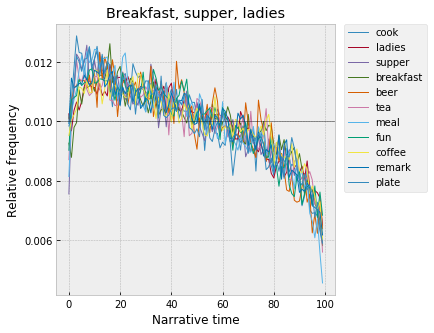

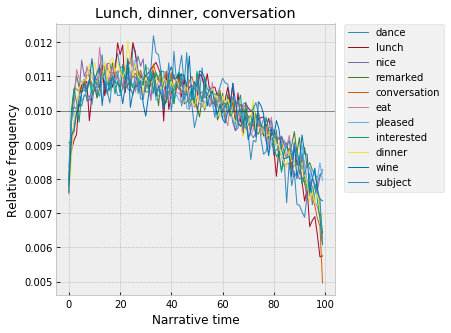

In [27]:
cohorts.plot_cohorts([96], 'Breakfast, supper, ladies')
cohorts.plot_cohorts([95], 'Lunch, dinner, conversation')

# Guns, murder

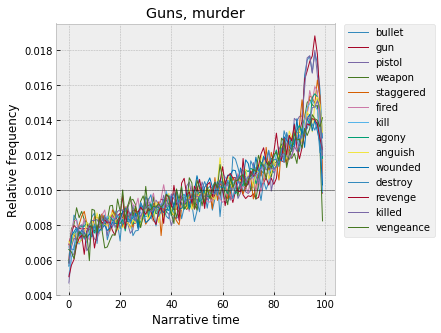

In [28]:
cohorts.plot_cohorts([37, 32, 49], 'Guns, murder')

# The trial

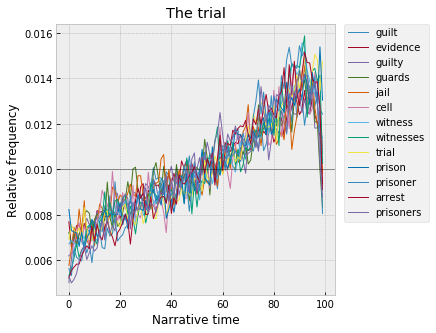

In [29]:
cohorts.plot_cohorts([50, 47, 40], 'The trial')

# War

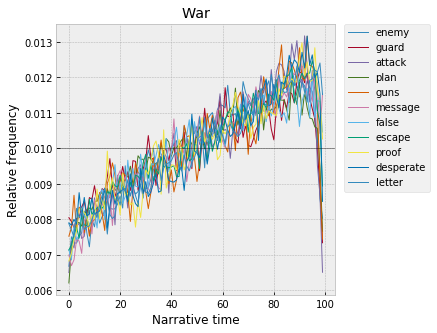

In [30]:
cohorts.plot_cohorts([70, 67], 'War')

# Happy endings

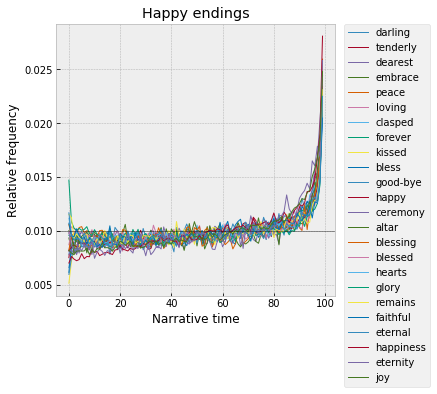

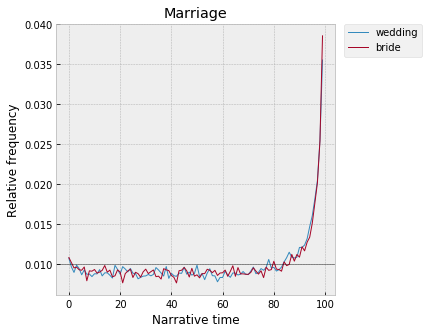

In [31]:
cohorts.plot_cohorts([66, 65, 64, 63, 62], 'Happy endings')
cohorts.plot_cohorts([52], 'Marriage')

# Sad endings

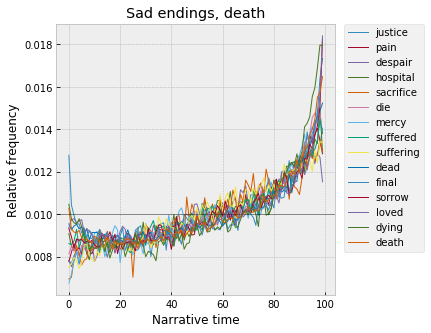

In [32]:
cohorts.plot_cohorts([73, 59], 'Sad endings, death')

# Dialogue

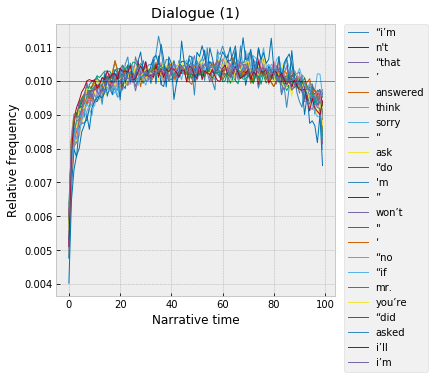

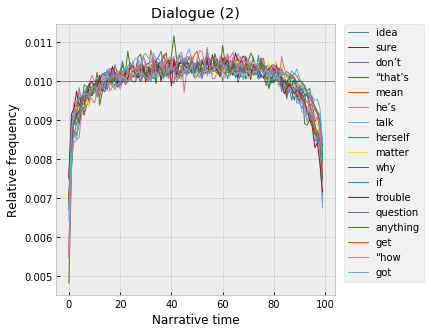

In [33]:
cohorts.plot_cohorts([18], 'Dialogue (1)')
cohorts.plot_cohorts([17], 'Dialogue (2)')
# cohorts.plot_cohorts([14], 'Dialogue')
# cohorts.plot_cohorts([12], 'Dialogue')

# Mental states

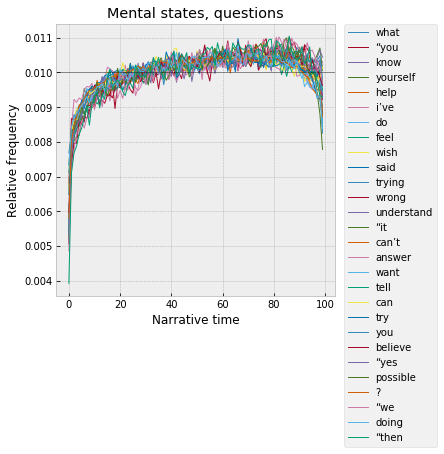

In [34]:
cohorts.plot_cohorts([23], 'Mental states, questions')

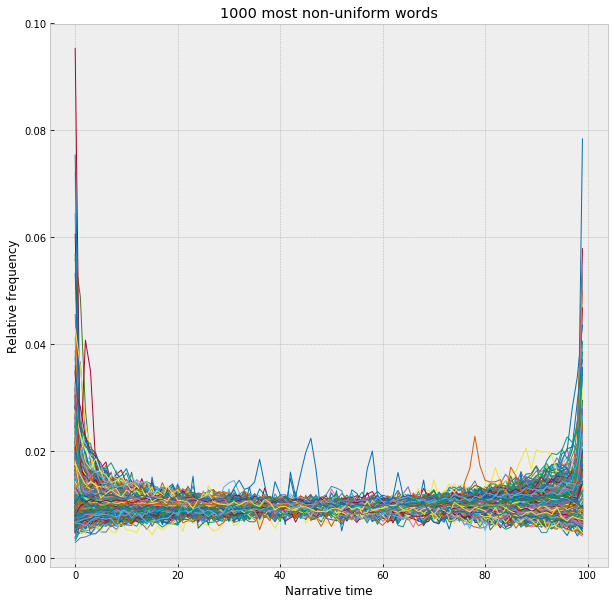

In [35]:
plt.figure(figsize=(10, 10))

for _, s in series.items():
    plt.plot(s/s.sum(), lw=1)

# plt.ylim((0, 0.025))
plt.title('1000 most non-uniform words')
plt.xlabel('Narrative time')
plt.ylabel('Relative frequency')
plt.show()